In [41]:
install.packages("ggplot2")
install.packages("MASS")
install.packages("forecast")
install.packages("TSA")
install.packages("tseries")
install.packages("dplyr")
install.packages("knitr")
install.packages("gridExtra")

Installing package into ‘/home/lyes/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/lyes/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/lyes/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/lyes/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/lyes/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [42]:
# Define the plot size
options(repr.plot.width = 20, repr.plot.height = 10)

# Load required libraries
library(ggplot2)
library(forecast)
library(tseries)
library(TSA)
library(dplyr)
library(gridExtra)
library(knitr)
library(MASS)

In [43]:
# Load the Bitcoin data
bitcoin_data <- read.csv("../data/bitcoin_data.csv")

In [44]:
# Convert the Date column to Date format
bitcoin_data$Date <- as.Date(substr(bitcoin_data$Date, 1, 10))

In [45]:
# Display the first few rows
cat("First 5 rows of data:\n")
print(head(bitcoin_data, 5))

First 5 rows of data:
        Date Close.Price..USD.
1 2014-09-17           457.334
2 2014-09-18           424.440
3 2014-09-19           394.796
4 2014-09-20           408.904
5 2014-09-21           398.821


In [46]:
# Display basic information about the dataset
cat("\nDataset info:\n")
str(bitcoin_data)


Dataset info:
'data.frame':	3758 obs. of  2 variables:
 $ Date             : Date, format: "2014-09-17" "2014-09-18" ...
 $ Close.Price..USD.: num  457 424 395 409 399 ...


In [47]:
# Display summary statistics
cat("\nSummary statistics:\n")
print(summary(bitcoin_data))


Summary statistics:
      Date            Close.Price..USD. 
 Min.   :2014-09-17   Min.   :   178.1  
 1st Qu.:2017-04-13   1st Qu.:  1224.9  
 Median :2019-11-08   Median :  9349.5  
 Mean   :2019-11-08   Mean   : 19566.2  
 3rd Qu.:2022-06-04   3rd Qu.: 30540.1  
 Max.   :2024-12-30   Max.   :106140.6  


In [48]:
# Create time series object
bitcoin_ts <- ts(bitcoin_data$Close.Price..USD., frequency = 365.25 / 7)

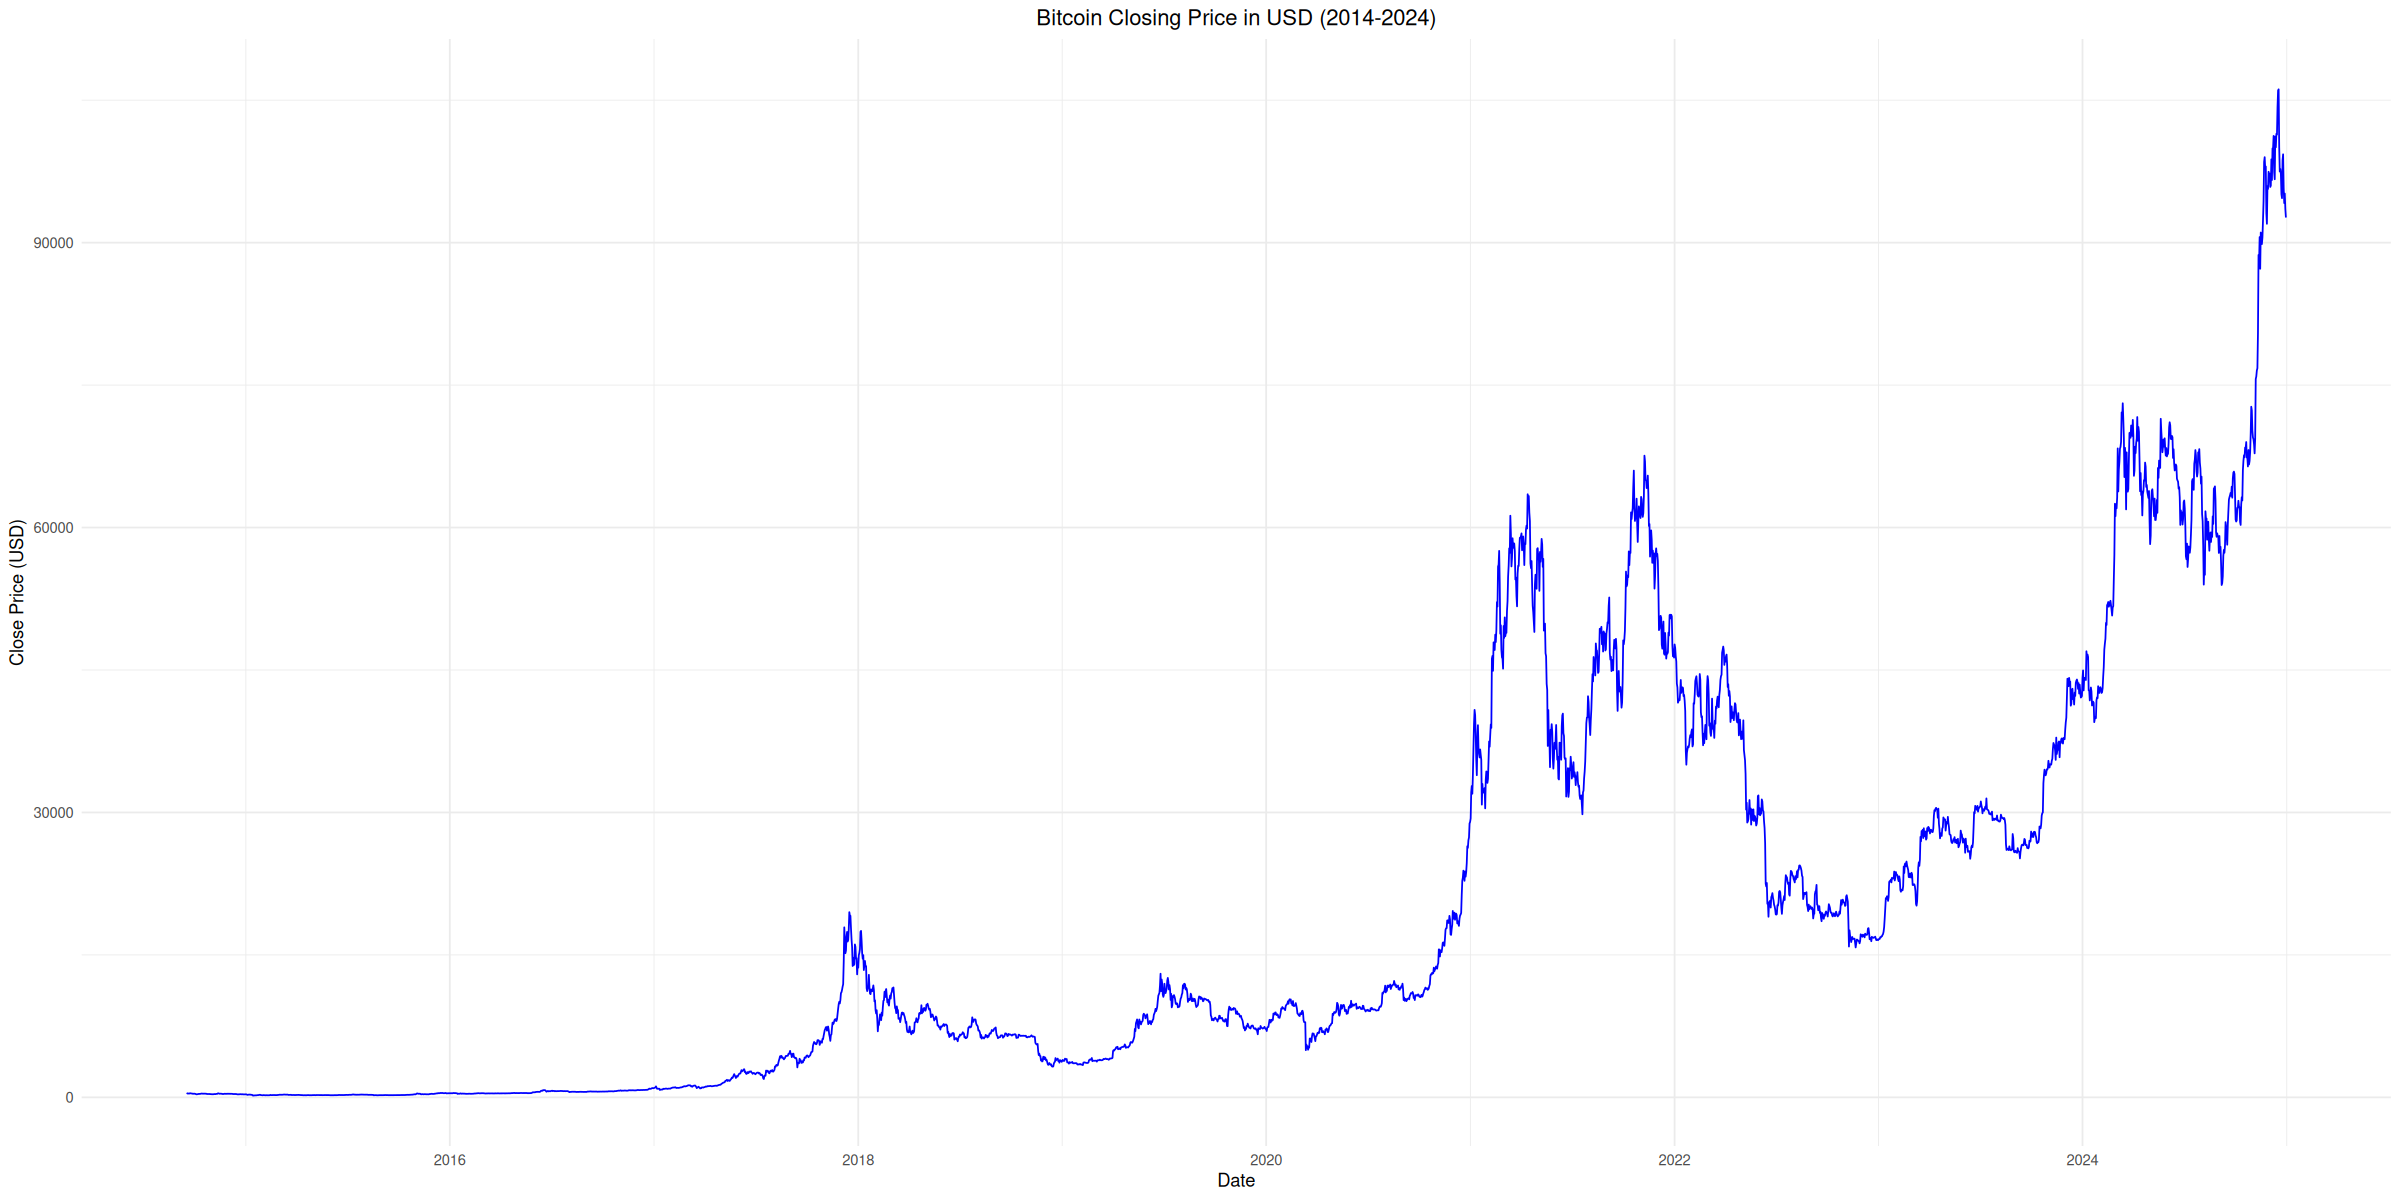

In [49]:
# Plot the Bitcoin closing price
par(bg = "white")
p1 <- ggplot(bitcoin_data, aes(x = Date, y = Close.Price..USD.)) +
  geom_line(color = "blue") +
  labs(title = "Bitcoin Closing Price in USD (2014-2024)",
       x = "Date", y = "Close Price (USD)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(p1)

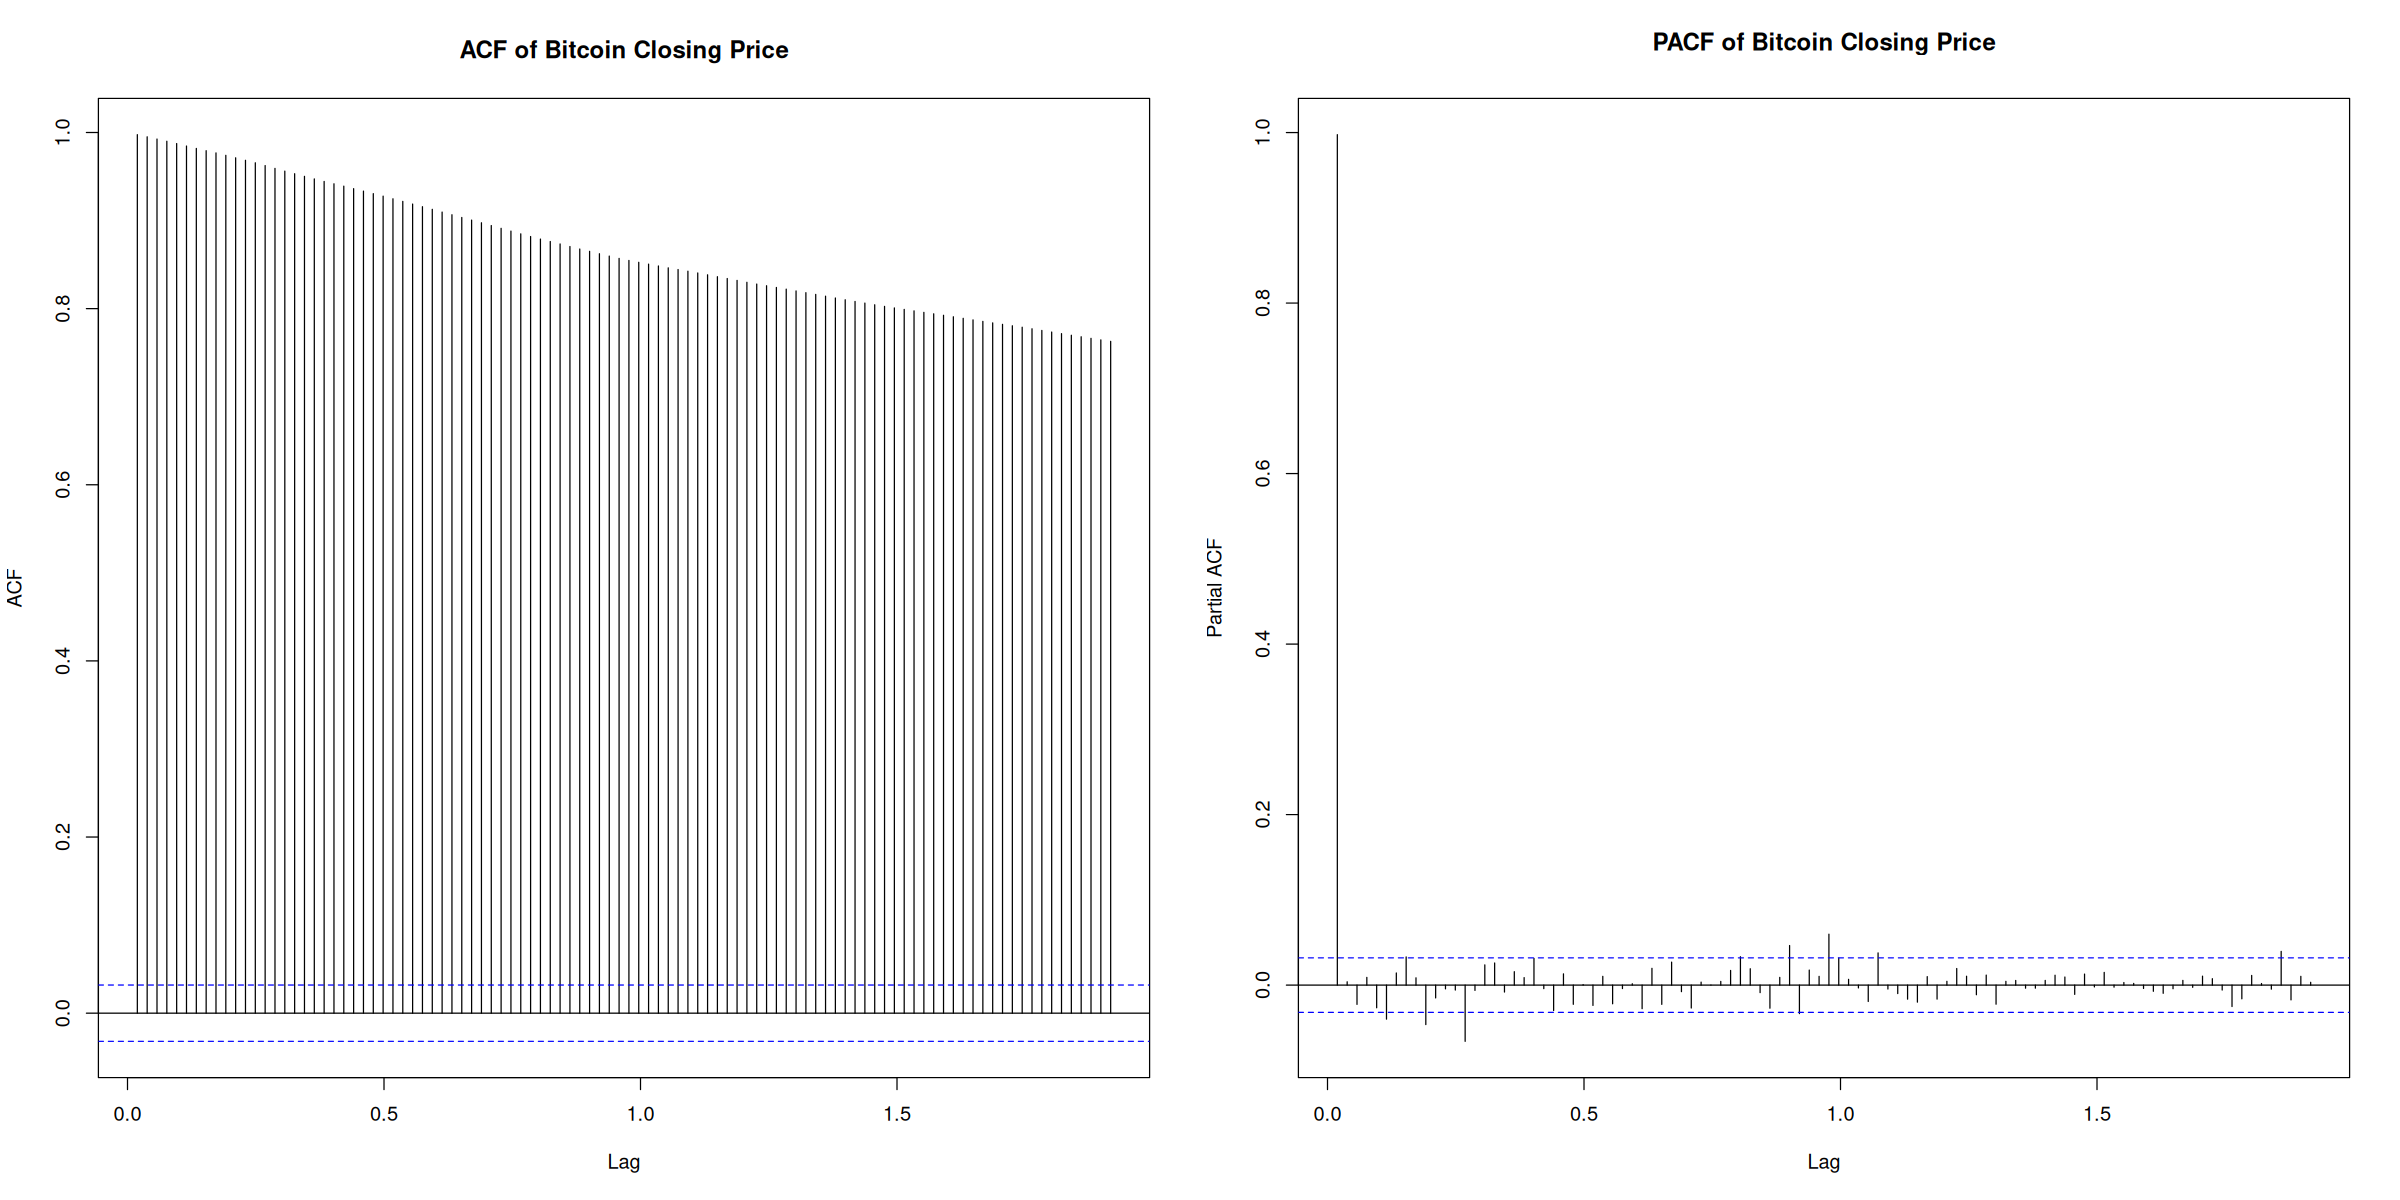

In [50]:
# Check for stationarity visually with ACF and PACF plots
par(bg = "white")
par(mfrow = c(1, 2))
acf(bitcoin_ts, main = "ACF of Bitcoin Closing Price", lag.max = 100)
pacf(bitcoin_ts, main = "PACF of Bitcoin Closing Price", lag.max = 100)
par(mfrow = c(1, 1))


In [51]:
# Formal stationarity test
adf_test <- adf.test(bitcoin_ts)
print("Augmented Dickey-Fuller Test for Stationarity:")
print(adf_test)

[1] "Augmented Dickey-Fuller Test for Stationarity:"

	Augmented Dickey-Fuller Test

data:  bitcoin_ts
Dickey-Fuller = -1.4842, Lag order = 15, p-value = 0.7967
alternative hypothesis: stationary



In [52]:
# Box-Cox transformation to stabilize variance
lambda <- BoxCox.lambda(bitcoin_ts)
cat("\nOptimal lambda for Box-Cox transformation:", lambda, "\n")


Optimal lambda for Box-Cox transformation: -0.0109352 


In [53]:
# Apply the Box-Cox transformation
bitcoin_boxcox <- BoxCox(bitcoin_ts, lambda)

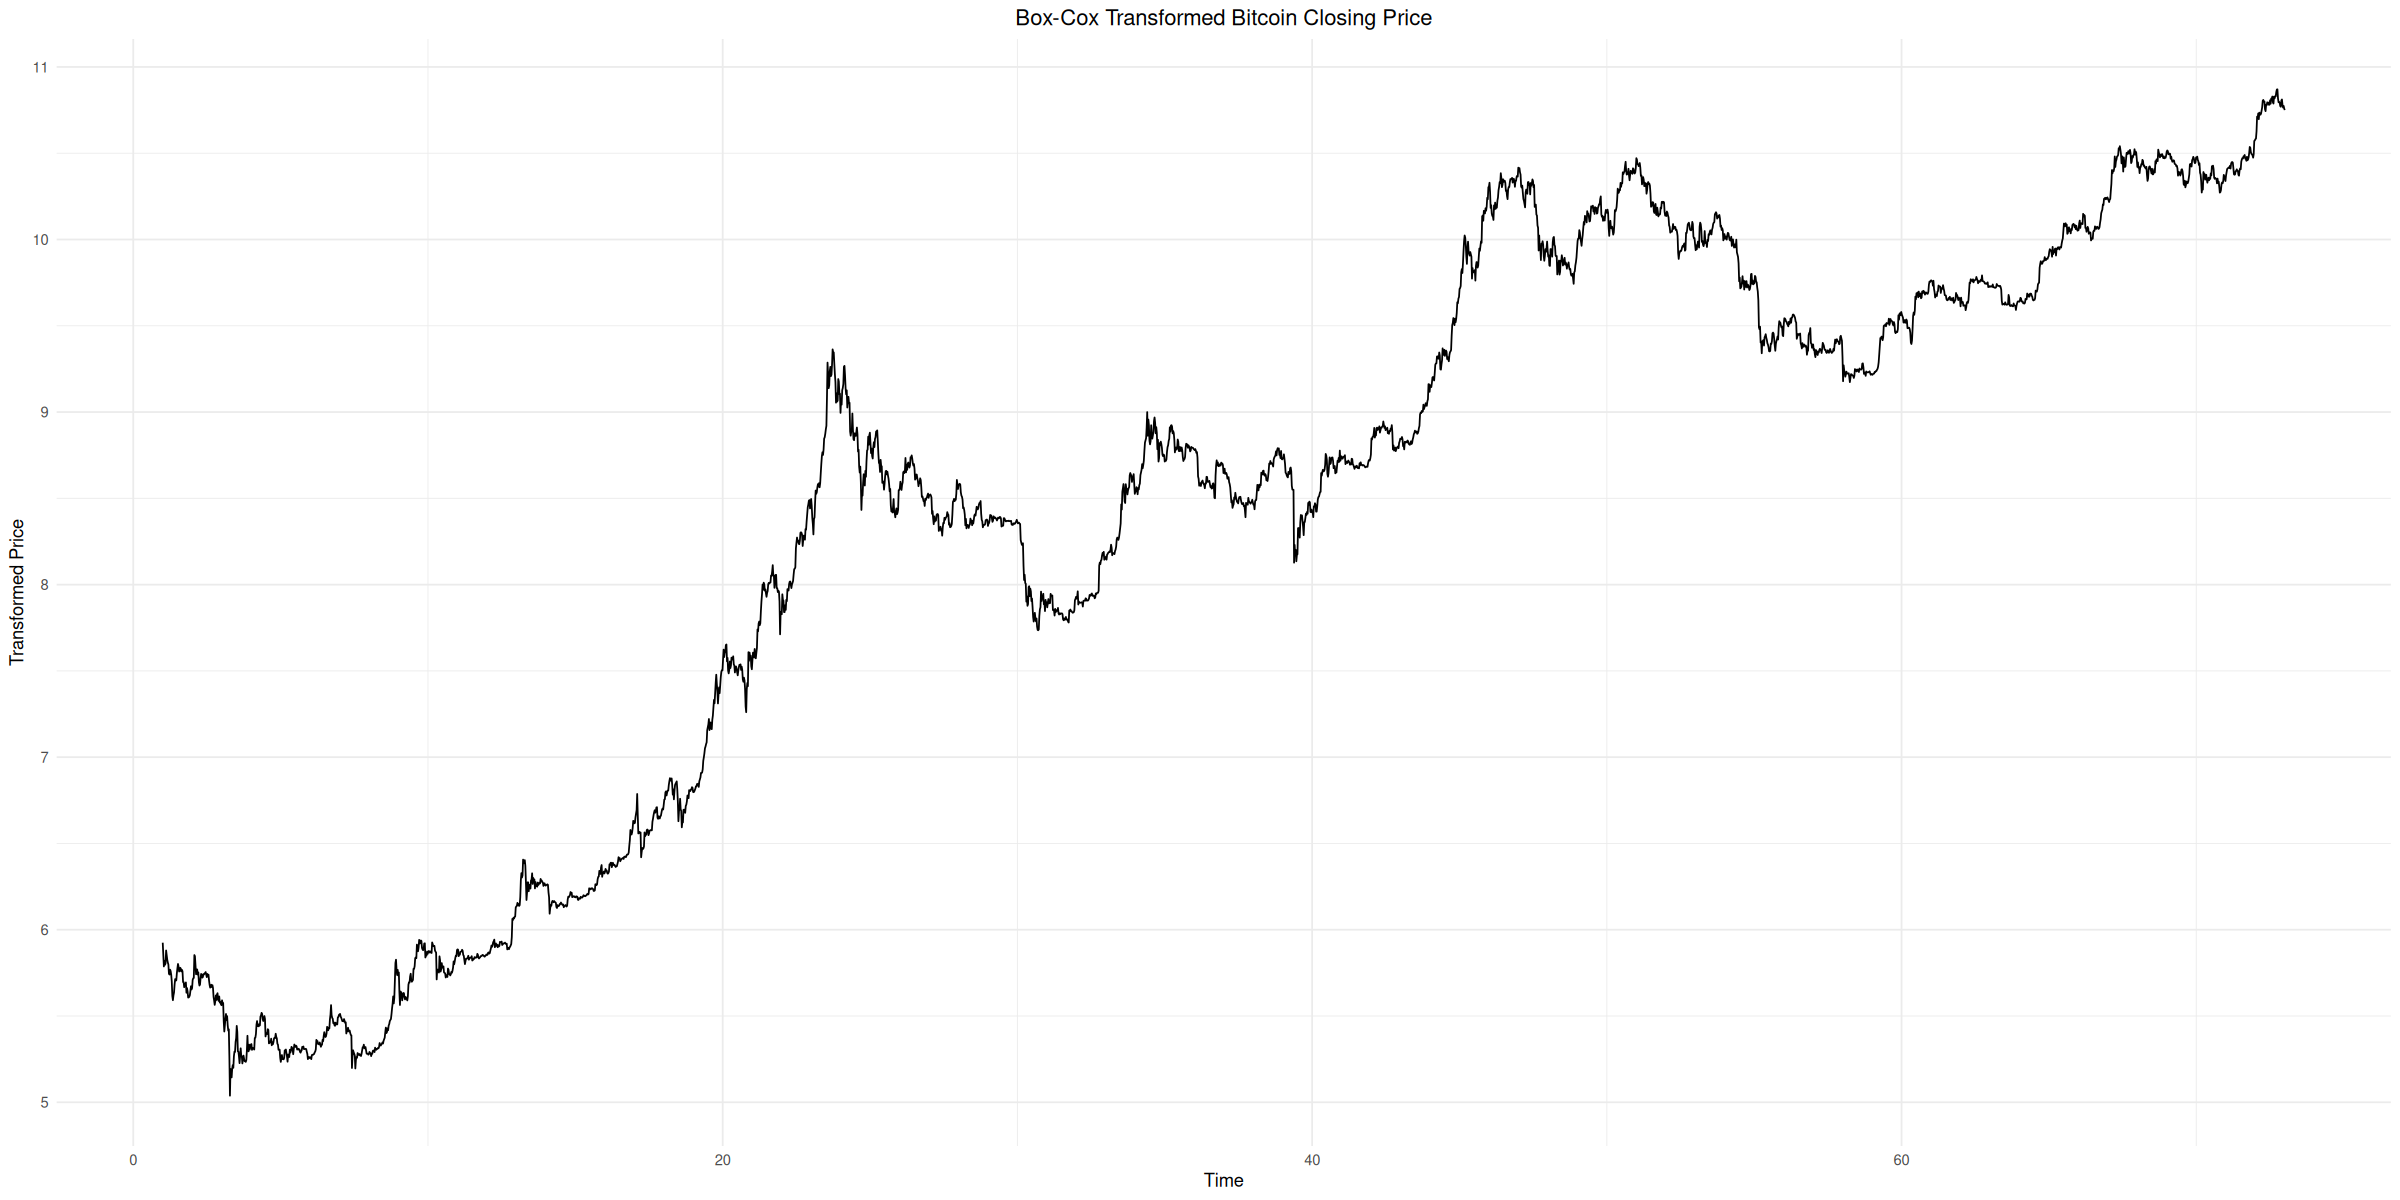

In [54]:
# Plot the Box-Cox transformed series
p2 <- autoplot(bitcoin_boxcox) +
  labs(title = "Box-Cox Transformed Bitcoin Closing Price",
       x = "Time", y = "Transformed Price") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(p2)

In [55]:
# Check if Box-Cox transformation helped with stationarity
adf_test_boxcox <- adf.test(bitcoin_boxcox)
print("Augmented Dickey-Fuller Test after Box-Cox transformation:")
print(adf_test_boxcox)

[1] "Augmented Dickey-Fuller Test after Box-Cox transformation:"

	Augmented Dickey-Fuller Test

data:  bitcoin_boxcox
Dickey-Fuller = -1.7262, Lag order = 15, p-value = 0.6943
alternative hypothesis: stationary



In [56]:
# Still not stationary, let's difference the series
bitcoin_d1 <- diff(bitcoin_boxcox)

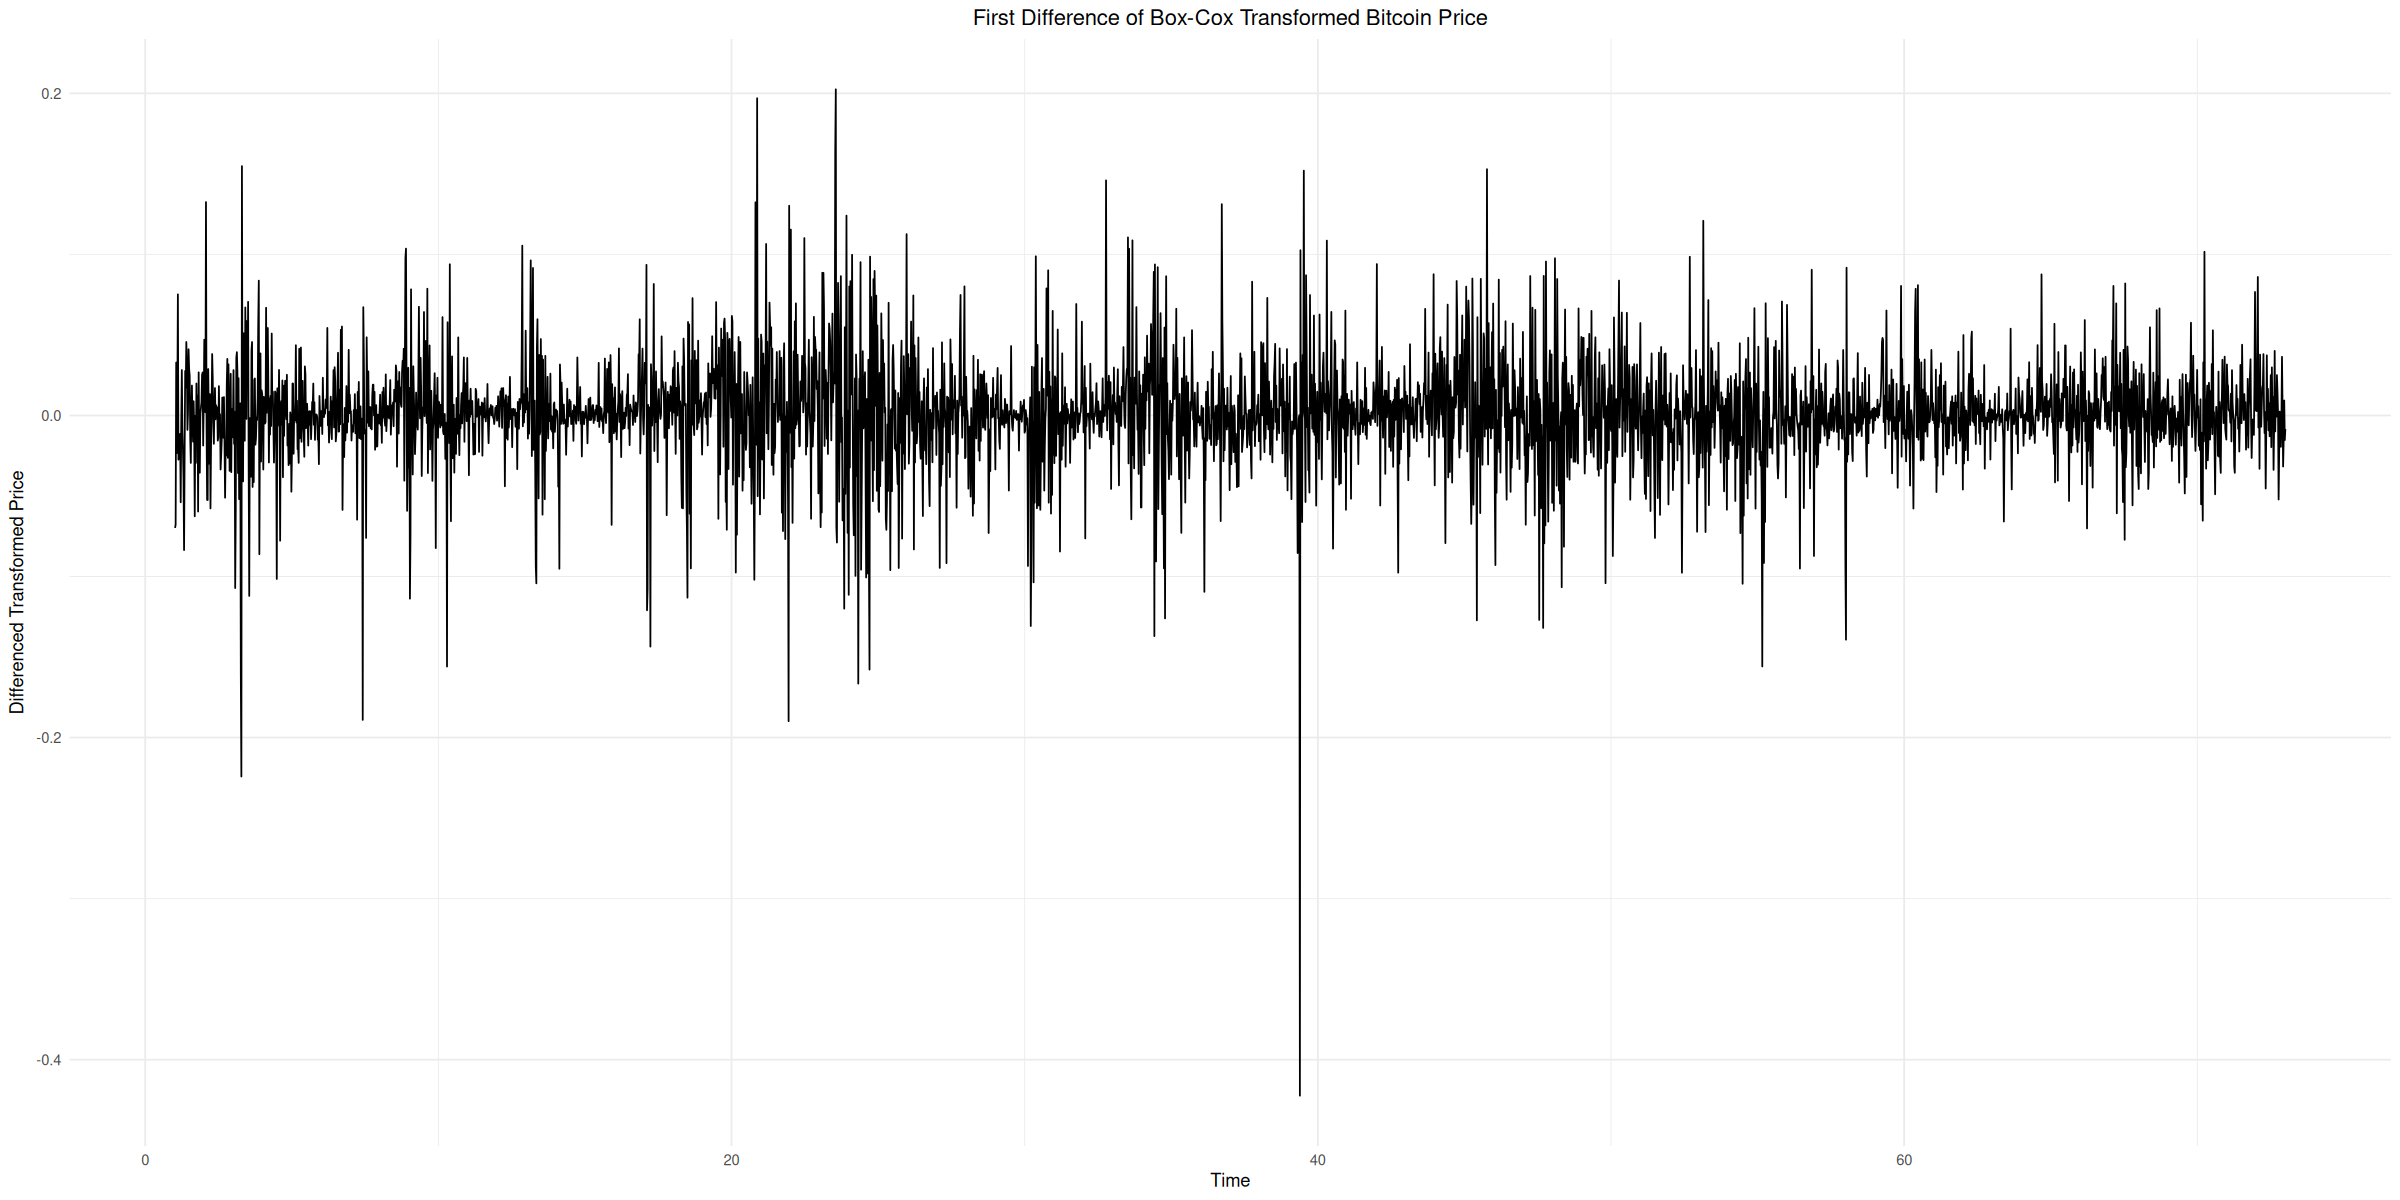

In [57]:
# Plot the differenced series
p3 <- autoplot(bitcoin_d1) +
  labs(title = "First Difference of Box-Cox Transformed Bitcoin Price",
       x = "Time", y = "Differenced Transformed Price") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(p3)

In [58]:
# Check if differencing helped with stationarity
adf_test_d1 <- adf.test(bitcoin_d1)
print("Augmented Dickey-Fuller Test after differencing:")
print(adf_test_d1)

Warning message in adf.test(bitcoin_d1):
“p-value smaller than printed p-value”


[1] "Augmented Dickey-Fuller Test after differencing:"

	Augmented Dickey-Fuller Test

data:  bitcoin_d1
Dickey-Fuller = -14.722, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary



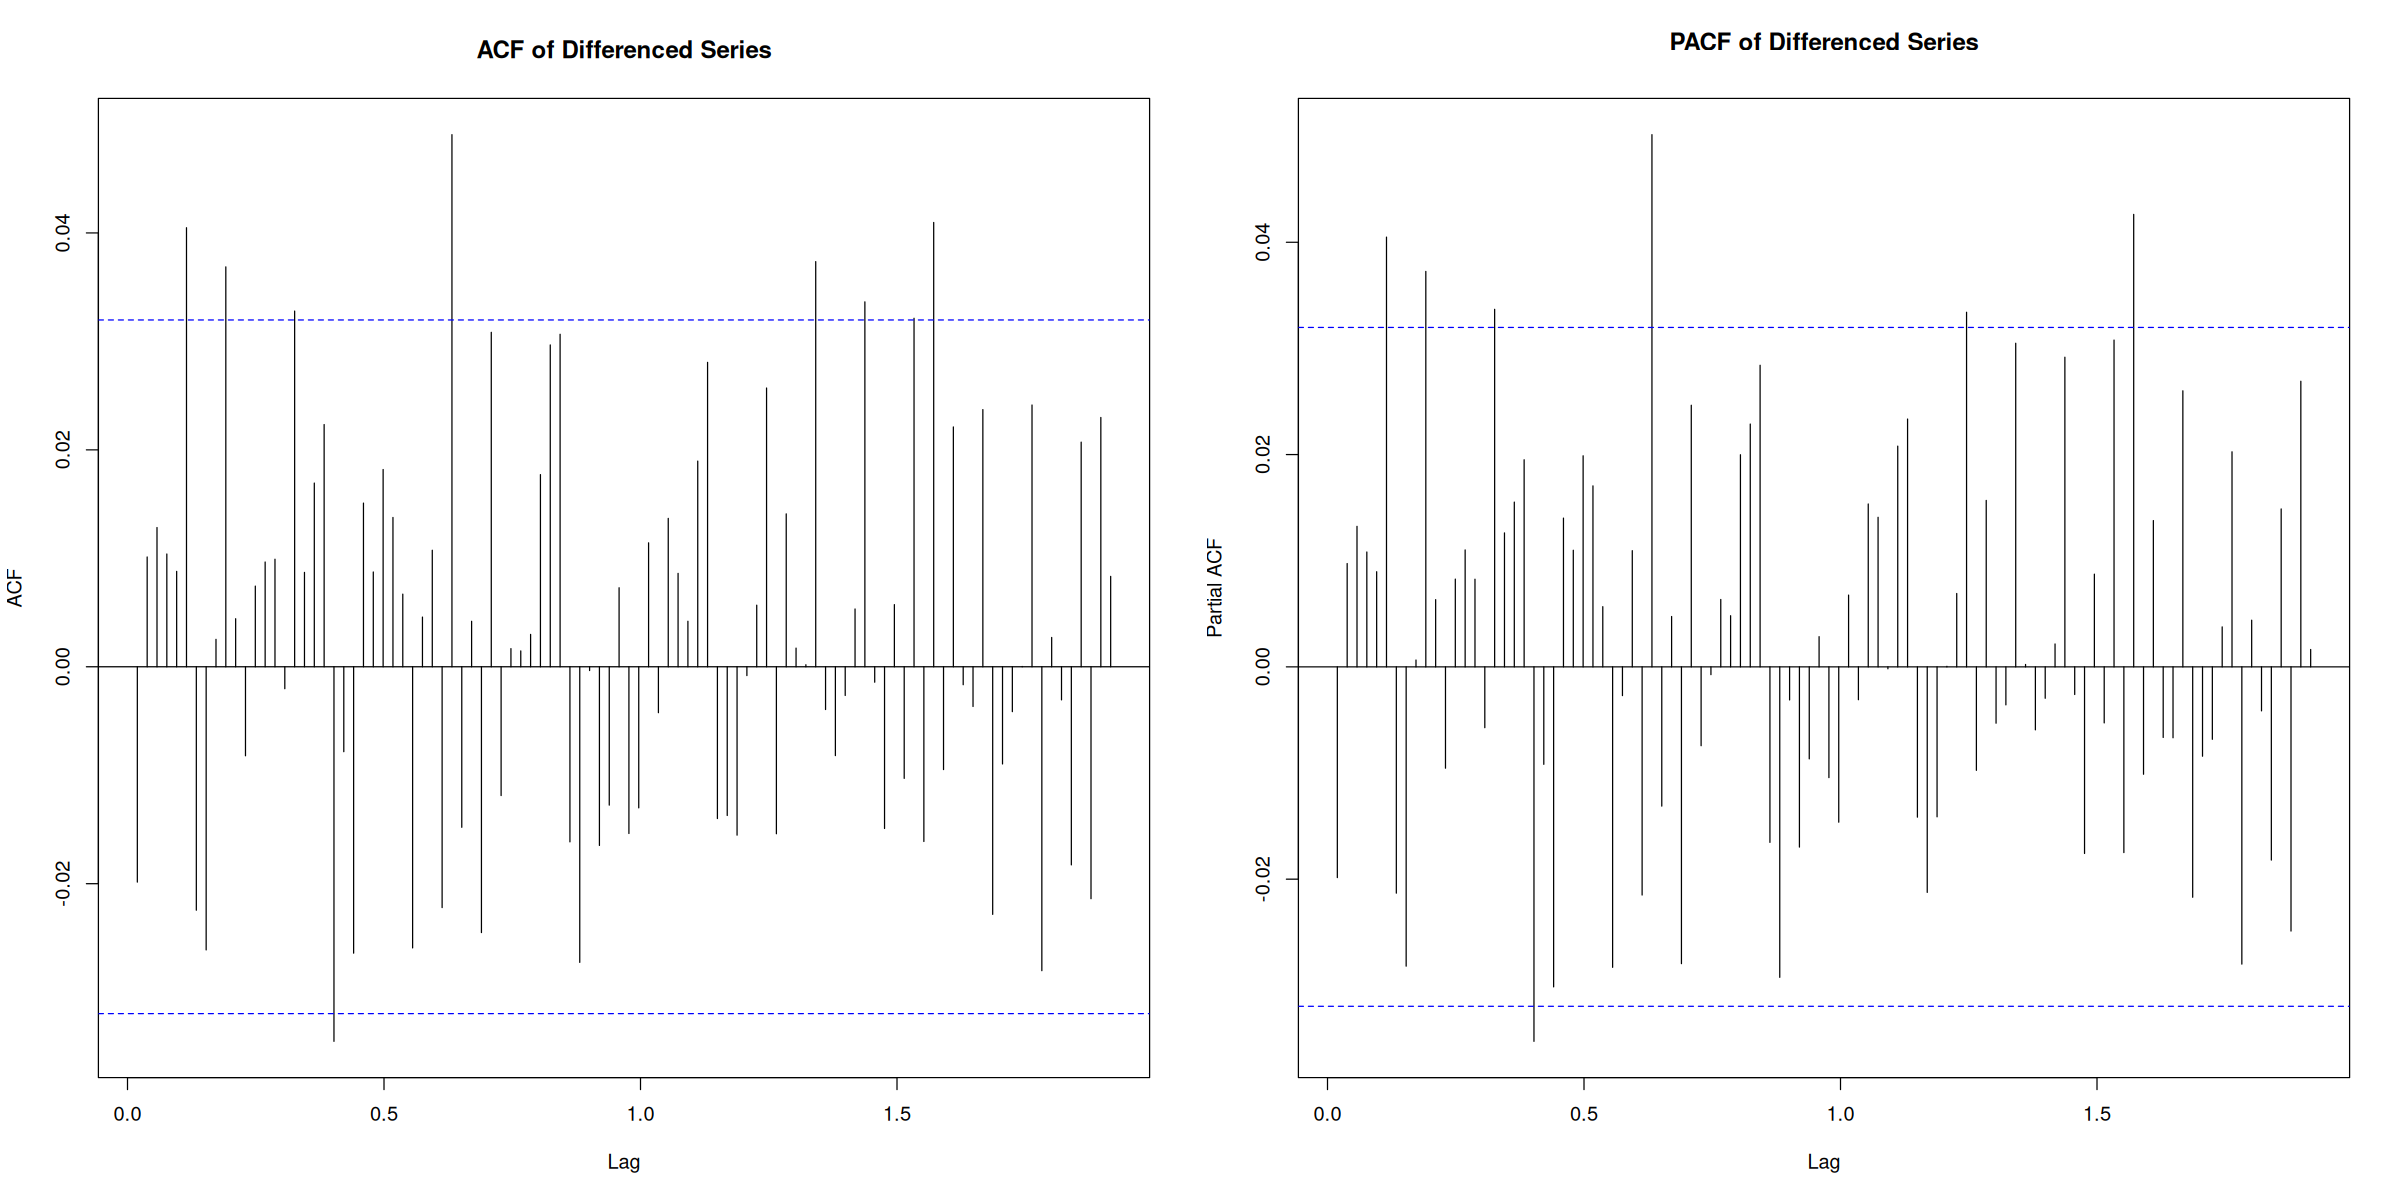

In [61]:
# Check ACF and PACF of differenced series
par(bg = "white")
par(mfrow = c(1, 2))
acf(bitcoin_d1, main = "ACF of Differenced Series", lag.max = 100)
pacf(bitcoin_d1, main = "PACF of Differenced Series", lag.max = 100)
par(mfrow = c(1, 1))

In [ ]:
# Split the data for forecasting validation
n <- length(bitcoin_ts)
train_size <- n - 30  # Leave last 30 observations for testing

# Use direct subsetting instead
bitcoin_train <- ts(bitcoin_ts[1:train_size], frequency = frequency(bitcoin_ts))
bitcoin_test <- ts(bitcoin_ts[(train_size+1):n],
                   frequency = frequency(bitcoin_ts))

In [67]:
# Apply transformations to training data
bitcoin_train_boxcox <- BoxCox(bitcoin_train, lambda)

In [68]:
# Fit auto.arima model on training data
fit_auto <- auto.arima(bitcoin_train_boxcox, d=1, 
                      seasonal=FALSE,
                      stepwise=TRUE,
                      approximation=FALSE)
summary(fit_auto)

Series: bitcoin_train_boxcox 
ARIMA(0,1,0) with drift 

Coefficients:
       drift
      0.0013
s.e.  0.0005

sigma^2 = 0.001103:  log likelihood = 7402.6
AIC=-14801.2   AICc=-14801.19   BIC=-14788.75

Training set error measures:
                       ME       RMSE        MAE          MPE      MAPE
Training set 1.588912e-06 0.03319763 0.02164508 -0.001140384 0.2688559
                  MASE        ACF1
Training set 0.1032122 -0.01995785

In [70]:
# Manual model selection
fit_arima1 <- Arima(bitcoin_train_boxcox, order = c(1, 1, 1))
fit_arima2 <- Arima(bitcoin_train_boxcox, order = c(2, 1, 2))
fit_arima3 <- Arima(bitcoin_train_boxcox, order = c(1, 1, 0))
fit_arima4 <- Arima(bitcoin_train_boxcox, order = c(0, 1, 1))

In [71]:
# Compare models
models <- list(auto=fit_auto, arima111=fit_arima1, arima212=fit_arima2, 
               arima110=fit_arima3, arima011=fit_arima4)
model_names <- c("auto.arima", "ARIMA(1,1,1)", "ARIMA(2,1,2)", "ARIMA(1,1,0)", "ARIMA(0,1,1)")
aic_values <- sapply(models, function(x) x$aicc)
bic_values <- sapply(models, function(x) x$bic)

In [72]:
# Create comparison table
model_comparison <- data.frame(
  Model = model_names,
  AICc = aic_values,
  BIC = bic_values
)
model_comparison <- model_comparison[order(model_comparison$AICc),]
print("Model Comparison:")
print(model_comparison)

[1] "Model Comparison:"
                Model      AICc       BIC
auto       auto.arima -14801.19 -14788.75
arima212 ARIMA(2,1,2) -14797.22 -14766.12
arima110 ARIMA(1,1,0) -14796.69 -14784.25
arima011 ARIMA(0,1,1) -14796.66 -14784.22
arima111 ARIMA(1,1,1) -14794.09 -14775.43


In [73]:
# Choose the best model (lowest AICc)
best_model <- models[[which.min(aic_values)]]
print("Best model based on AICc:")
summary(best_model)

[1] "Best model based on AICc:"


Series: bitcoin_train_boxcox 
ARIMA(0,1,0) with drift 

Coefficients:
       drift
      0.0013
s.e.  0.0005

sigma^2 = 0.001103:  log likelihood = 7402.6
AIC=-14801.2   AICc=-14801.19   BIC=-14788.75

Training set error measures:
                       ME       RMSE        MAE          MPE      MAPE
Training set 1.588912e-06 0.03319763 0.02164508 -0.001140384 0.2688559
                  MASE        ACF1
Training set 0.1032122 -0.01995785


	Ljung-Box test

data:  Residuals from ARIMA(0,1,0) with drift
Q* = 135.8, df = 104.36, p-value = 0.02094

Model df: 0.   Total lags used: 104.357142857143



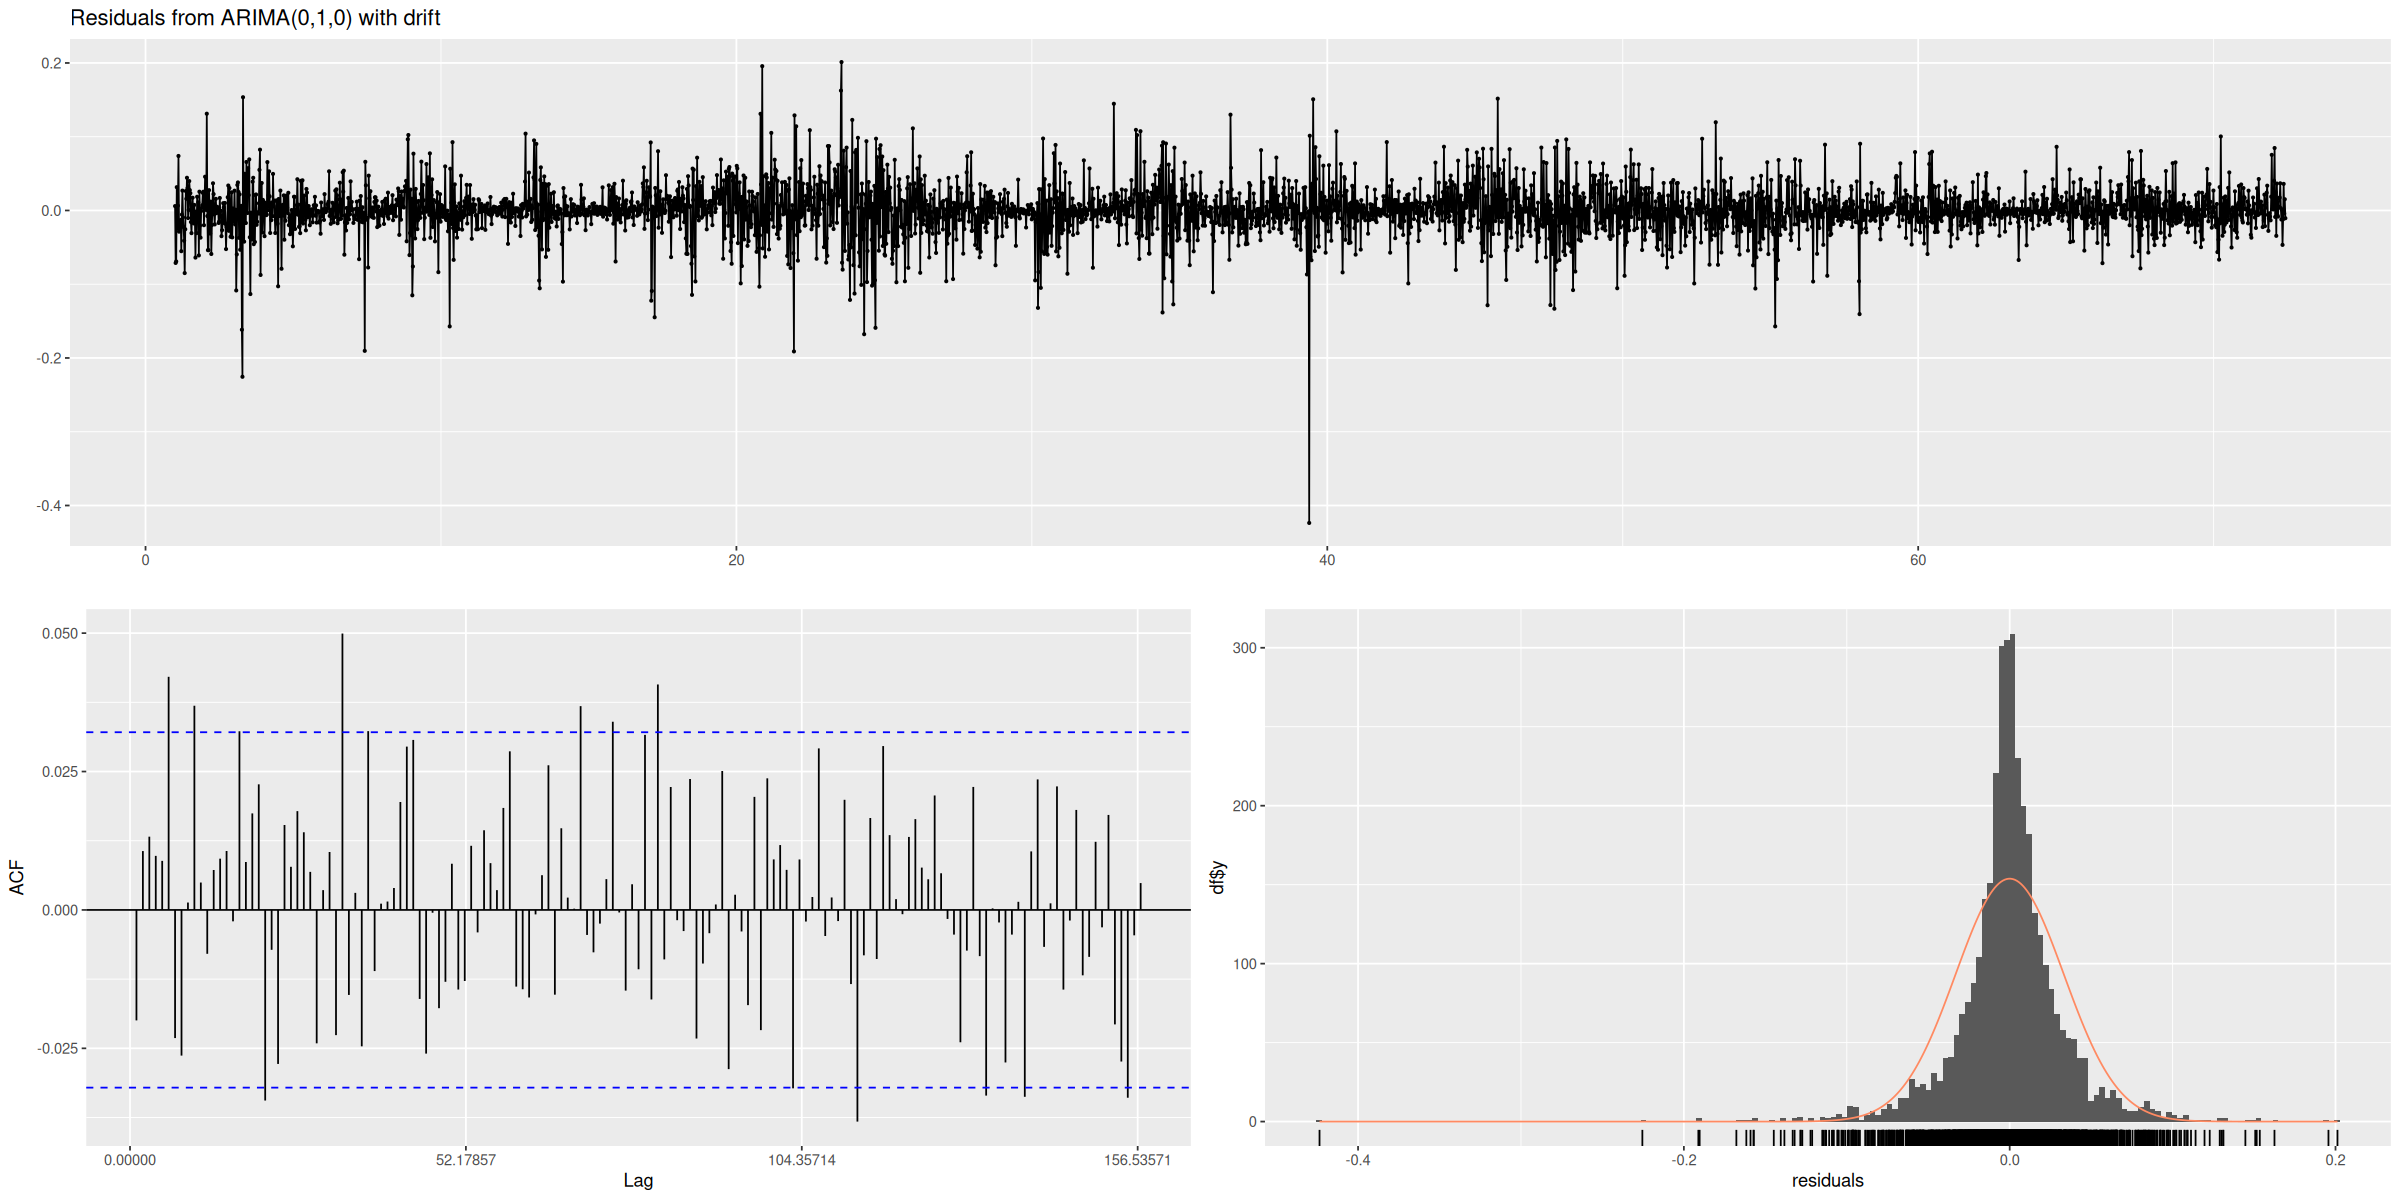

In [74]:

# Diagnostic checking
checkresiduals(best_model)

In [75]:
# Forecast with the best model
forecast_horizon <- length(bitcoin_test)
forecasts <- forecast(best_model, h=forecast_horizon)

In [76]:
# Inverse Box-Cox transform forecasts
forecasts_original <- InvBoxCox(forecasts$mean, lambda)

In [77]:
# Combine with actual test data for comparison
forecast_comparison <- data.frame(
  Date = tail(bitcoin_data$Date, forecast_horizon),
  Actual = as.numeric(bitcoin_test),
  Forecast = as.numeric(forecasts_original)
)

In [79]:
# Convert forecasts and actuals to plain numeric vectors
f_values <- as.numeric(forecasts_original)
a_values <- as.numeric(bitcoin_test)

# Calculate accuracy metrics manually
me <- mean(f_values - a_values)
rmse <- sqrt(mean((f_values - a_values)^2))
mae <- mean(abs(f_values - a_values))
mape <- mean(abs((f_values - a_values)/a_values)) * 100

# Create a data frame with the accuracy metrics
accuracy_metrics <- data.frame(
  ME = me,
  RMSE = rmse,
  MAE = mae,
  MAPE = mape
)

print("Forecast Accuracy Metrics:")
print(accuracy_metrics)


[1] "Forecast Accuracy Metrics:"
        ME     RMSE      MAE     MAPE
1 300.5315 3948.342 3193.526 3.248163


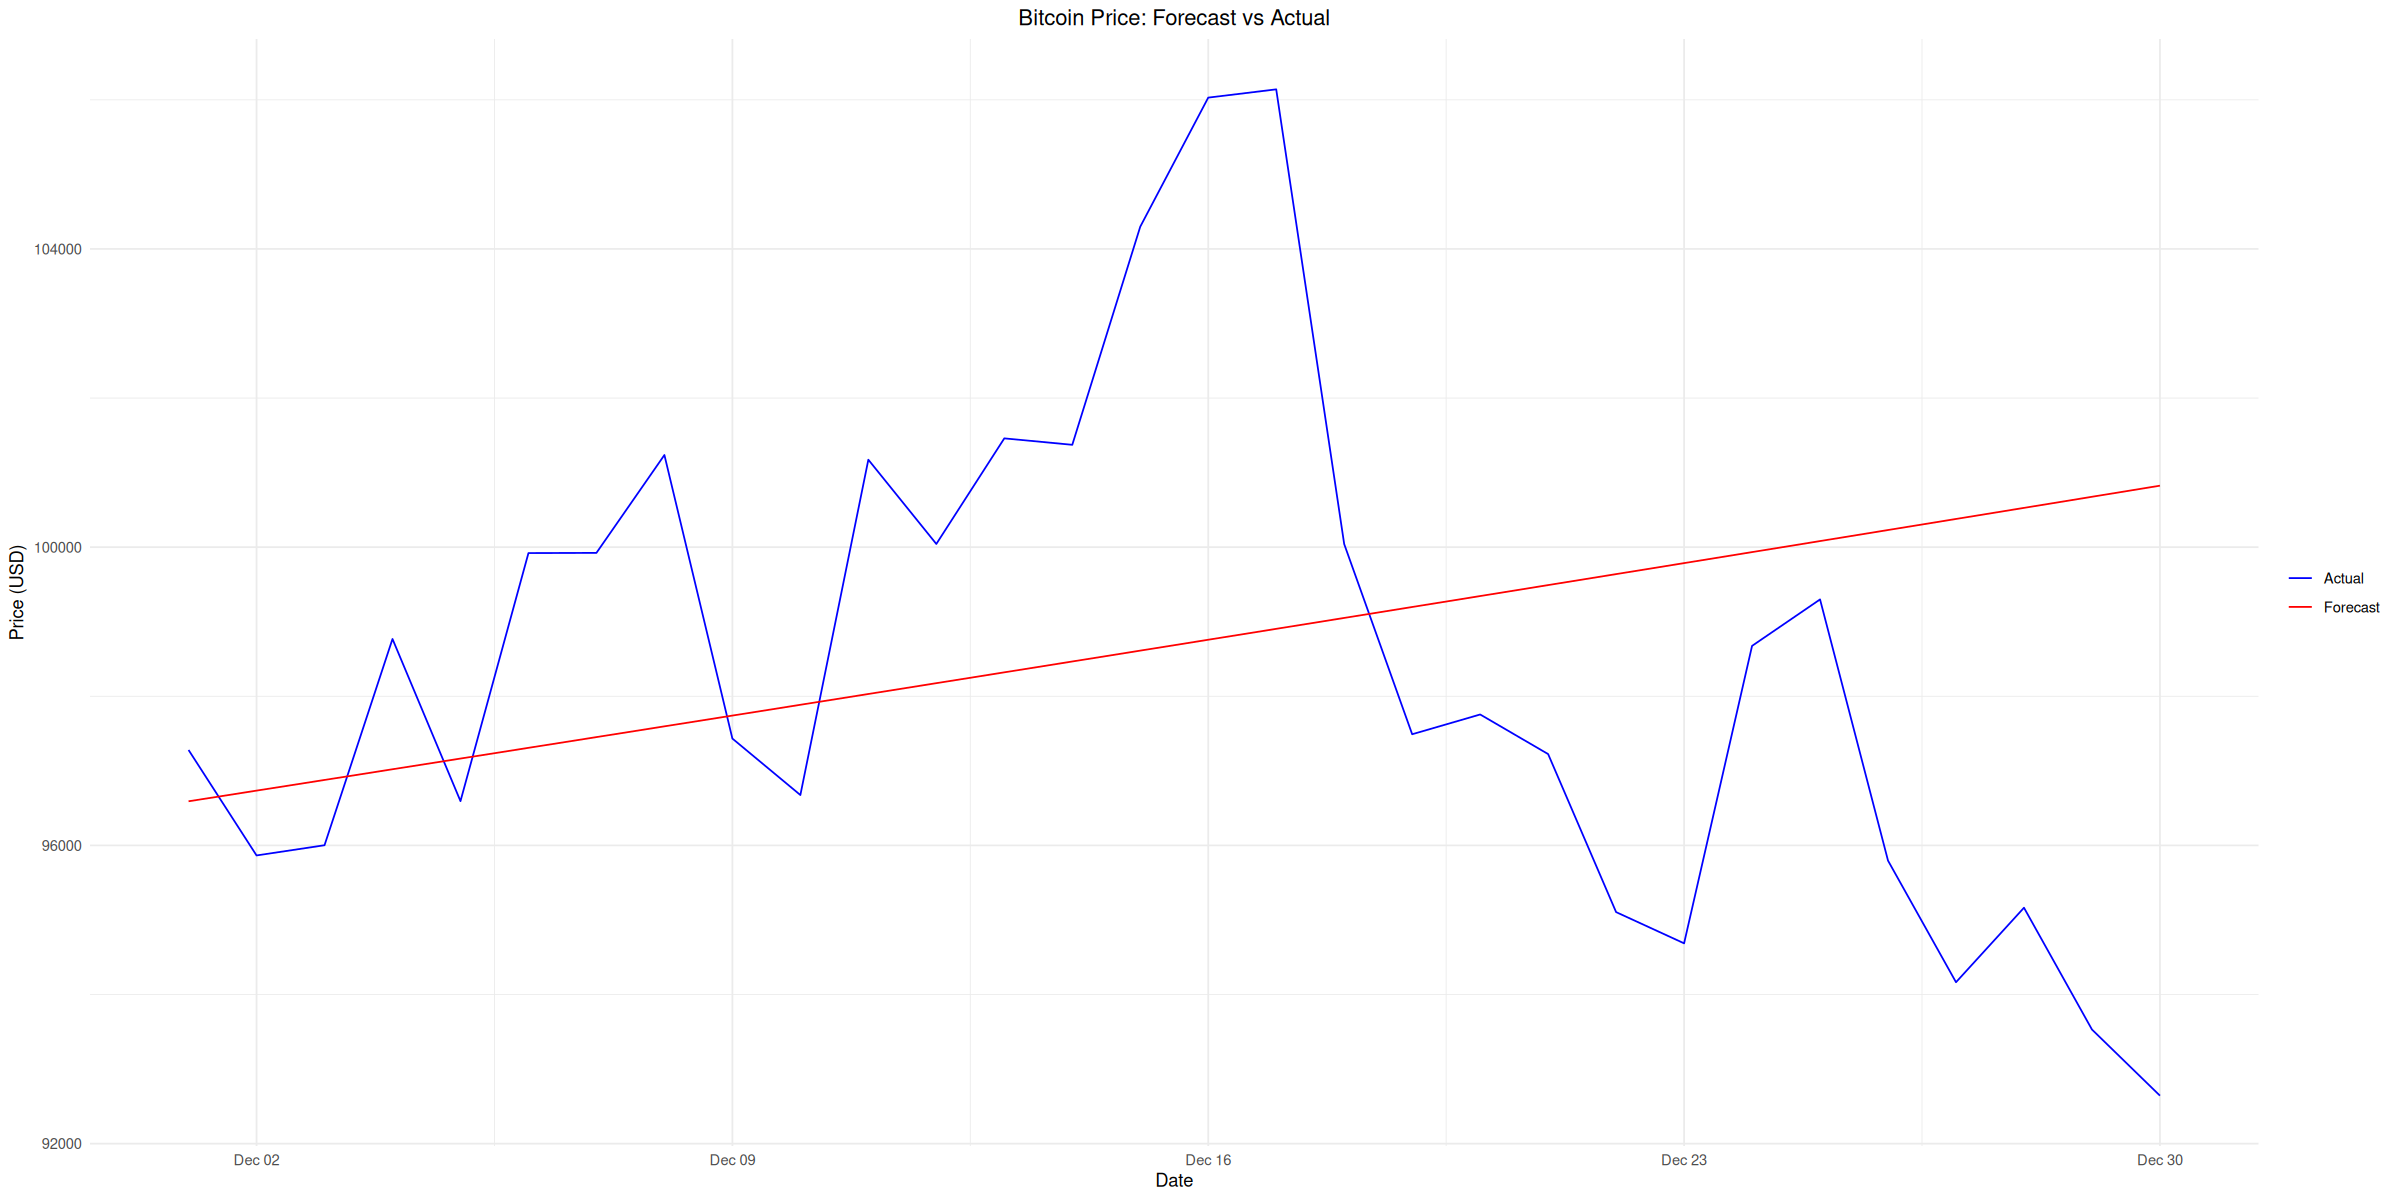

In [80]:
# Plot forecasts vs actual values
p4 <- ggplot(forecast_comparison, aes(x = Date)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Forecast, color = "Forecast")) +
  labs(title = "Bitcoin Price: Forecast vs Actual",
       x = "Date", y = "Price (USD)") +
  scale_color_manual(values = c("Actual" = "blue", "Forecast" = "red")) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank())
print(p4)

In [81]:
# Calculate percentage errors
forecast_comparison$PE <- (forecast_comparison$Forecast - forecast_comparison$Actual) / 
                           forecast_comparison$Actual * 100

In [82]:
# MAPE
mape <- mean(abs(forecast_comparison$PE))
cat("Mean Absolute Percentage Error (MAPE):", round(mape, 2), "%\n")

Mean Absolute Percentage Error (MAPE): 3.25 %


In [83]:
# Generate future forecasts
full_model <- Arima(BoxCox(bitcoin_ts, lambda), model=best_model)
future_forecast <- forecast(full_model, h=60)  # Forecast 60 periods ahead
future_forecast_original <- InvBoxCox(future_forecast$mean, lambda)

In [84]:
# Create dataframe for plotting
future_dates <- seq.Date(from = max(bitcoin_data$Date) + 1, 
                         by = "day", length.out = 60)
future_df <- data.frame(
  Date = future_dates,
  Forecast = as.numeric(future_forecast_original)
)

In [85]:
# Combine historical data with forecasts
combined_df <- rbind(
  data.frame(Date = bitcoin_data$Date, 
             Value = bitcoin_data$Close.Price..USD., 
             Type = "Historical"),
  data.frame(Date = future_df$Date, 
             Value = future_df$Forecast, 
             Type = "Forecast")
)

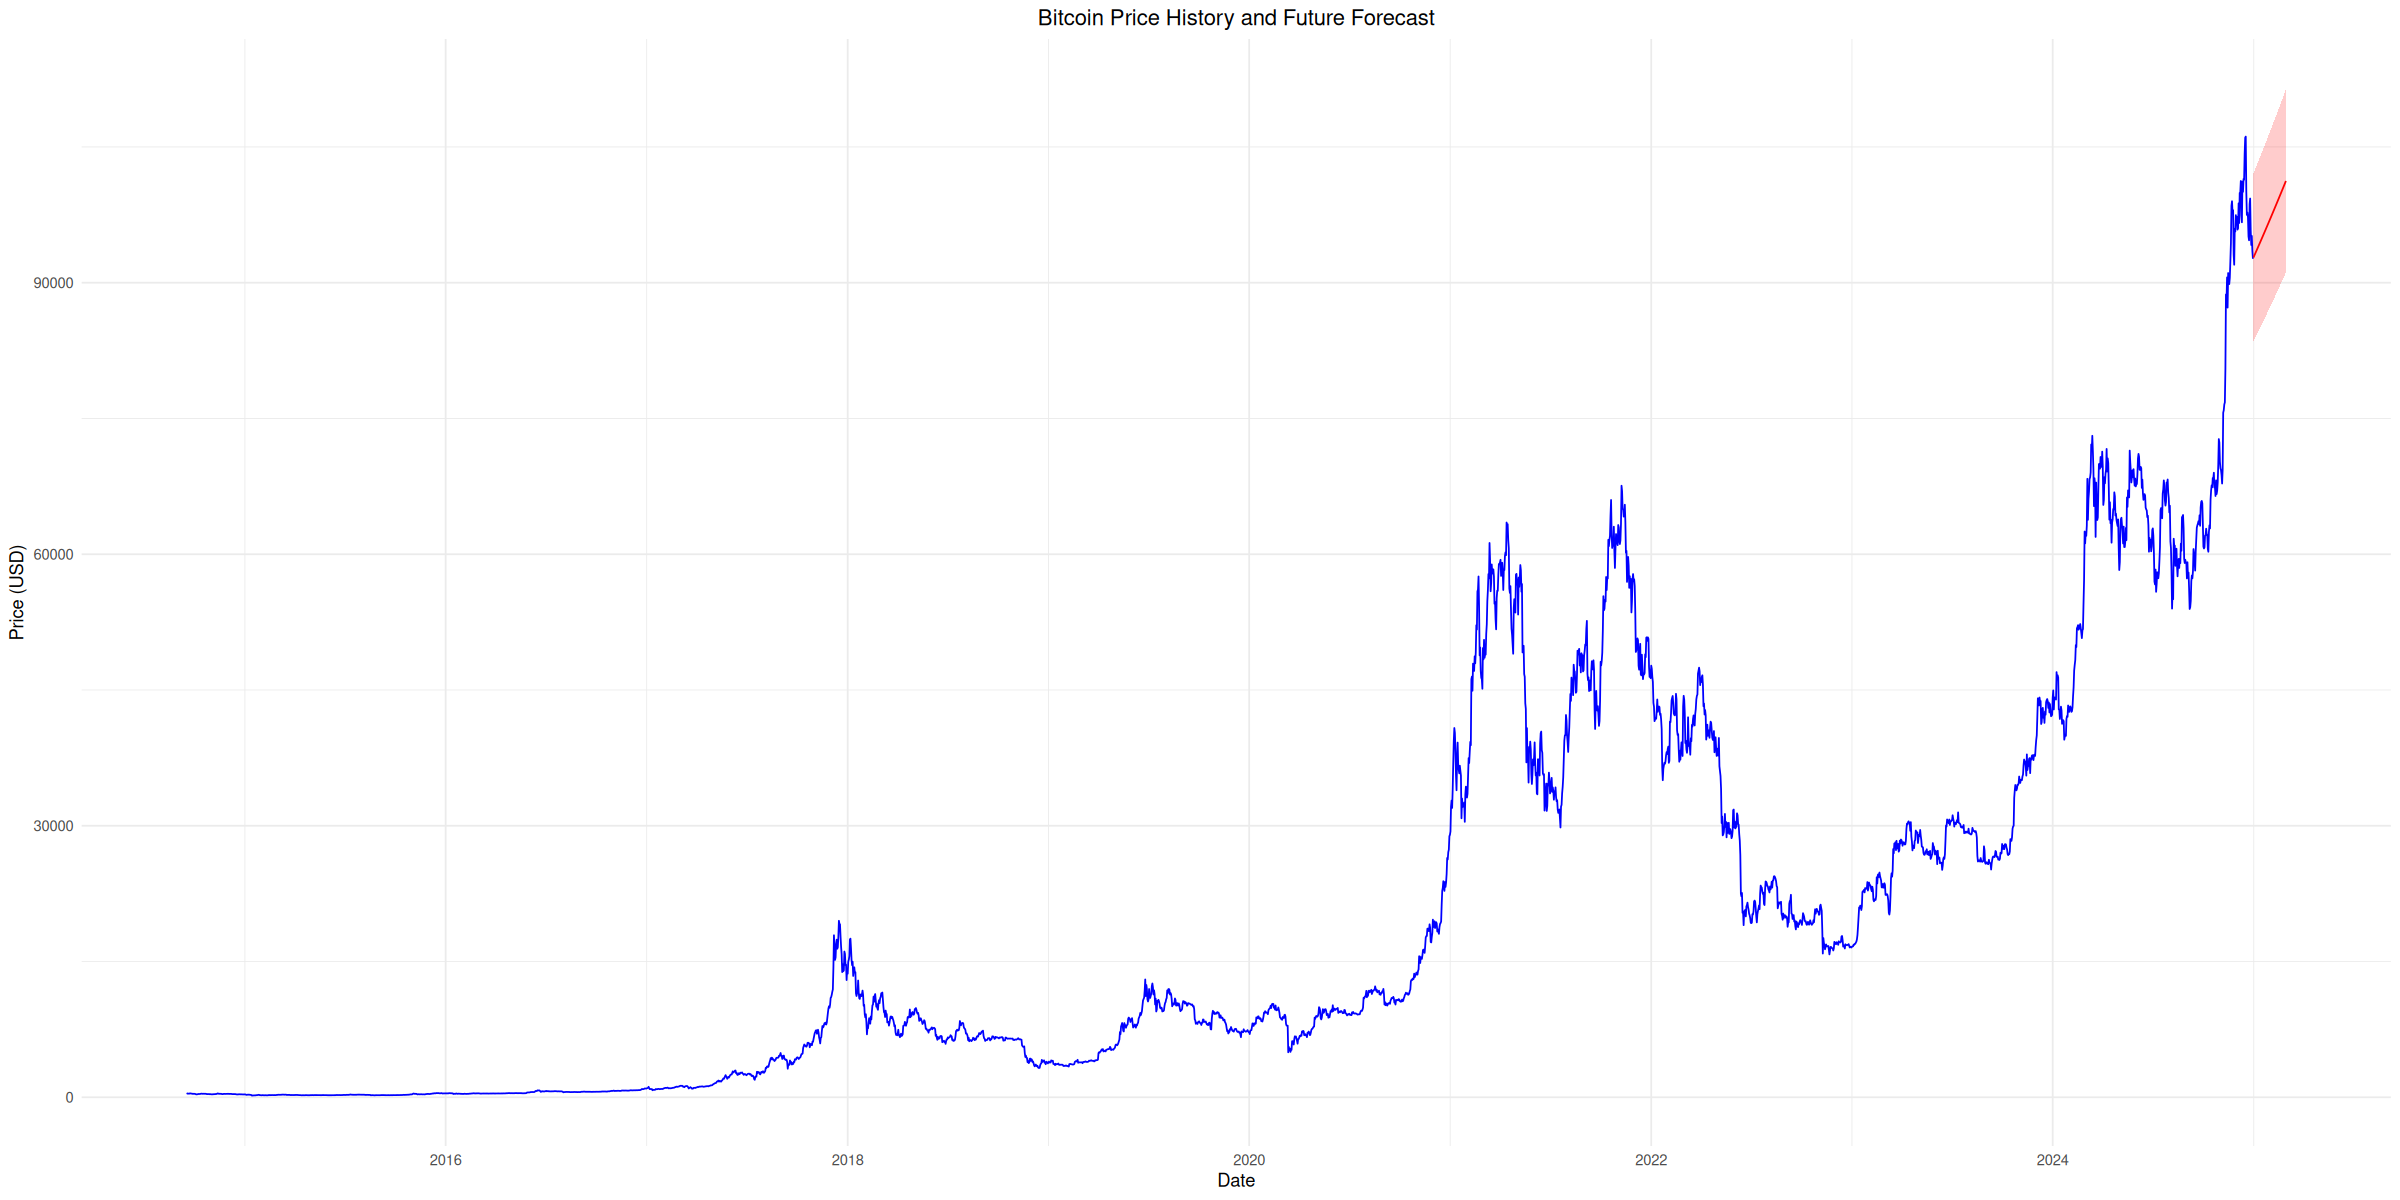

In [86]:
# Plot historical data and future forecasts
p5 <- ggplot() +
  geom_line(data = subset(combined_df, Type == "Historical"), 
            aes(x = Date, y = Value), color = "blue") +
  geom_line(data = subset(combined_df, Type == "Forecast"), 
            aes(x = Date, y = Value), color = "red") +
  geom_ribbon(data = subset(combined_df, Type == "Forecast"),
              aes(x = Date, 
                  ymin = future_df$Forecast * 0.9,  # Simple approximation of CI
                  ymax = future_df$Forecast * 1.1), 
              fill = "red", alpha = 0.2) +
  labs(title = "Bitcoin Price History and Future Forecast",
       x = "Date", y = "Price (USD)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(p5)

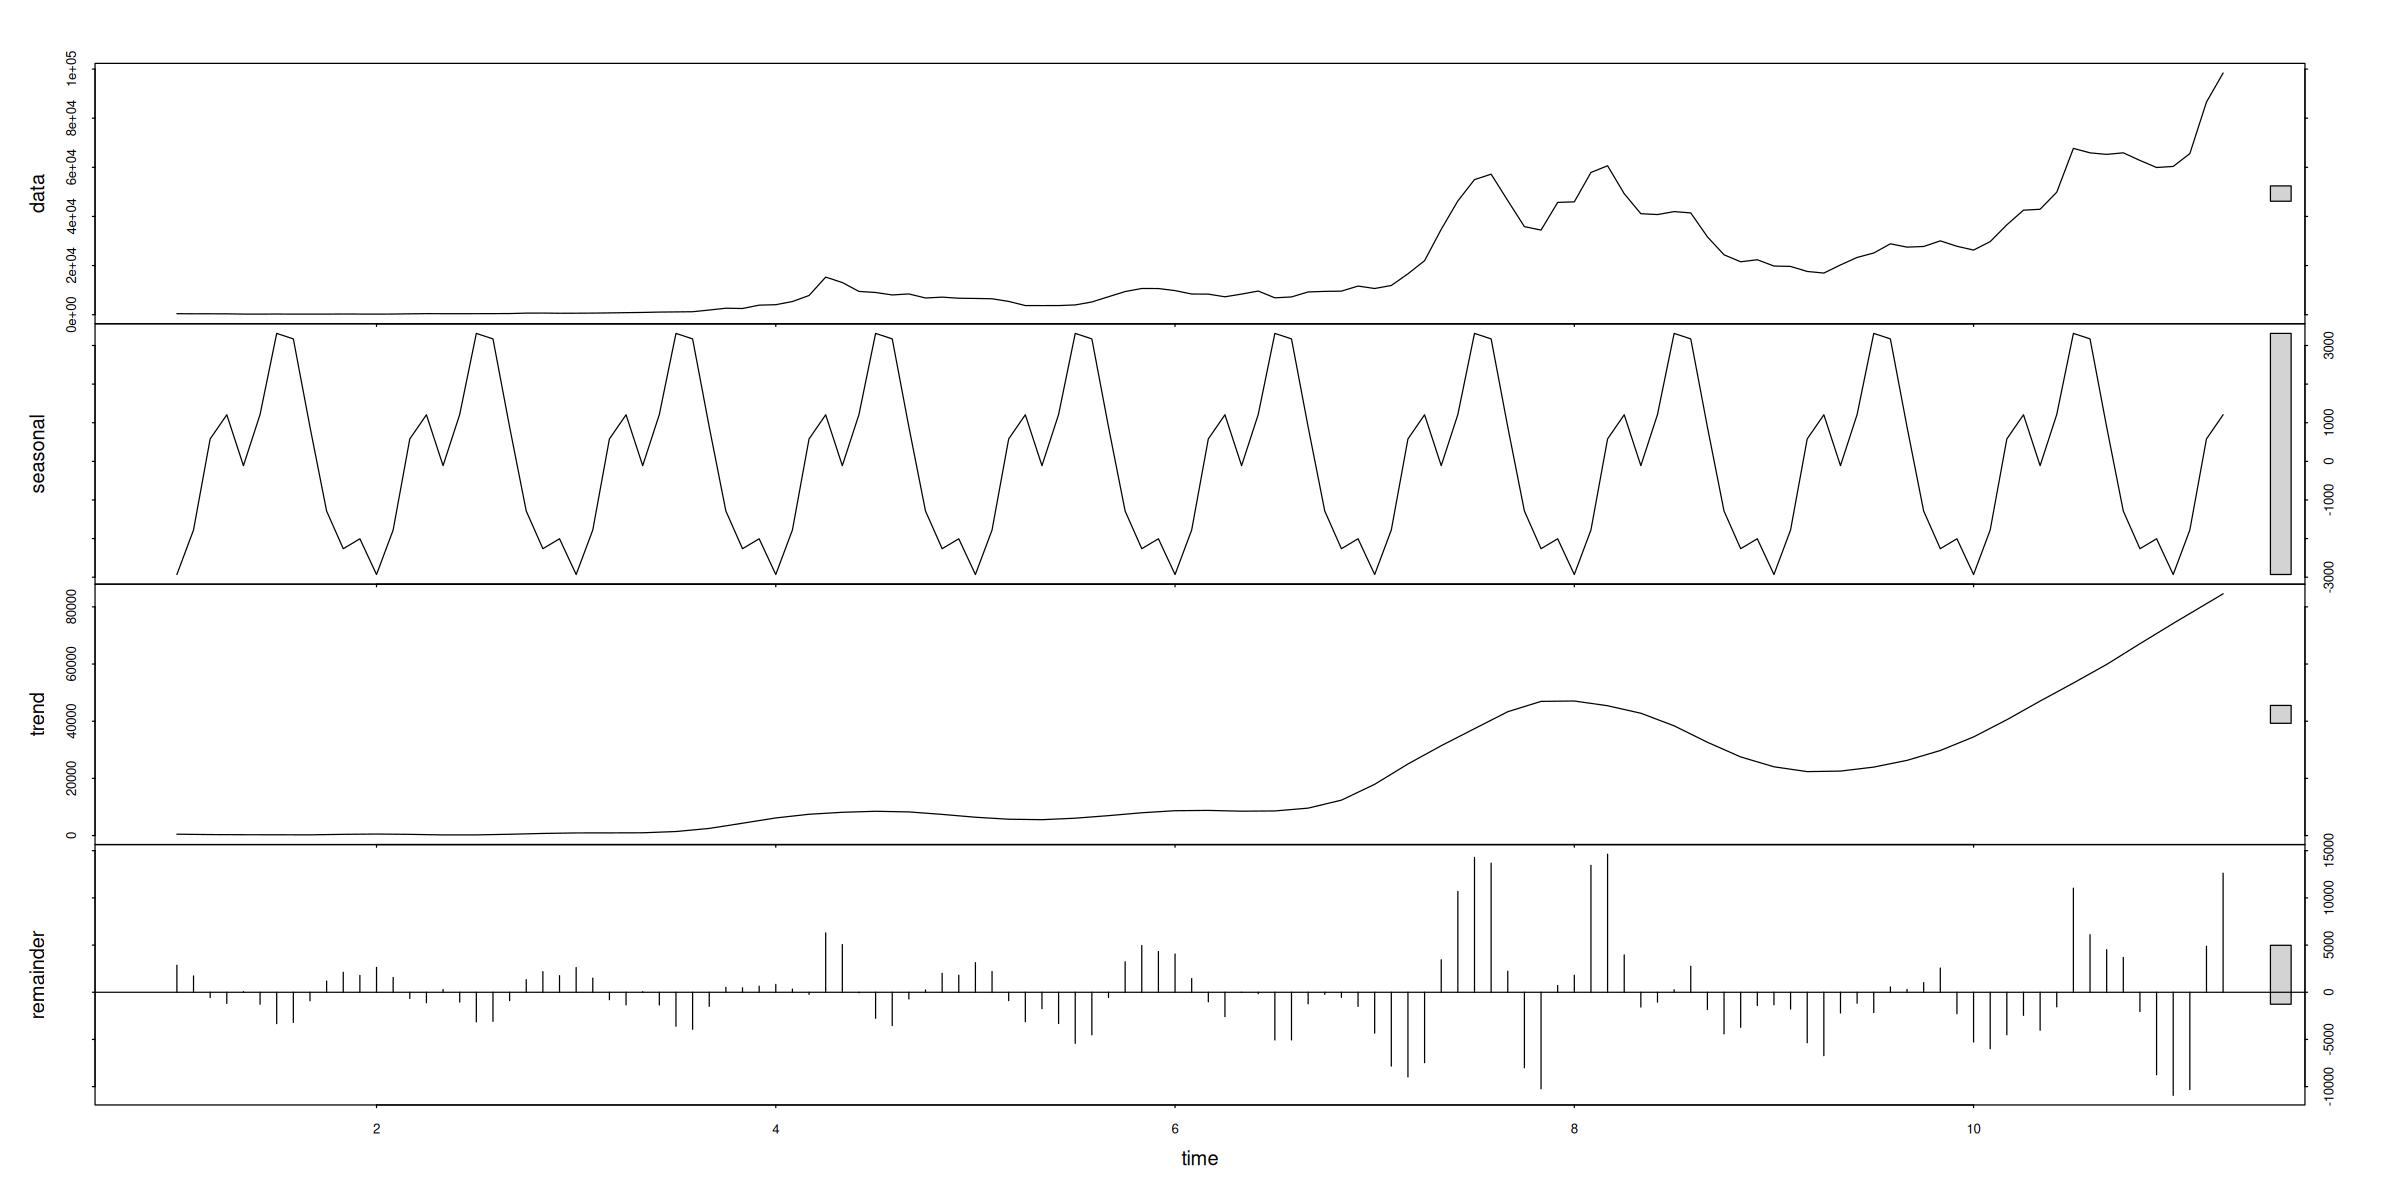

In [88]:
# Seasonal decomposition
bitcoin_monthly <- ts(aggregate(Close.Price..USD. ~ format(Date, "%Y-%m"), 
                               bitcoin_data, mean)$Close.Price..USD., frequency=12)
decomp <- stl(bitcoin_monthly, s.window="periodic")
par(bg = "white")
plot(decomp)

In [89]:
# Check for volatility clustering using squared returns
returns <- diff(log(bitcoin_ts))
squared_returns <- returns^2

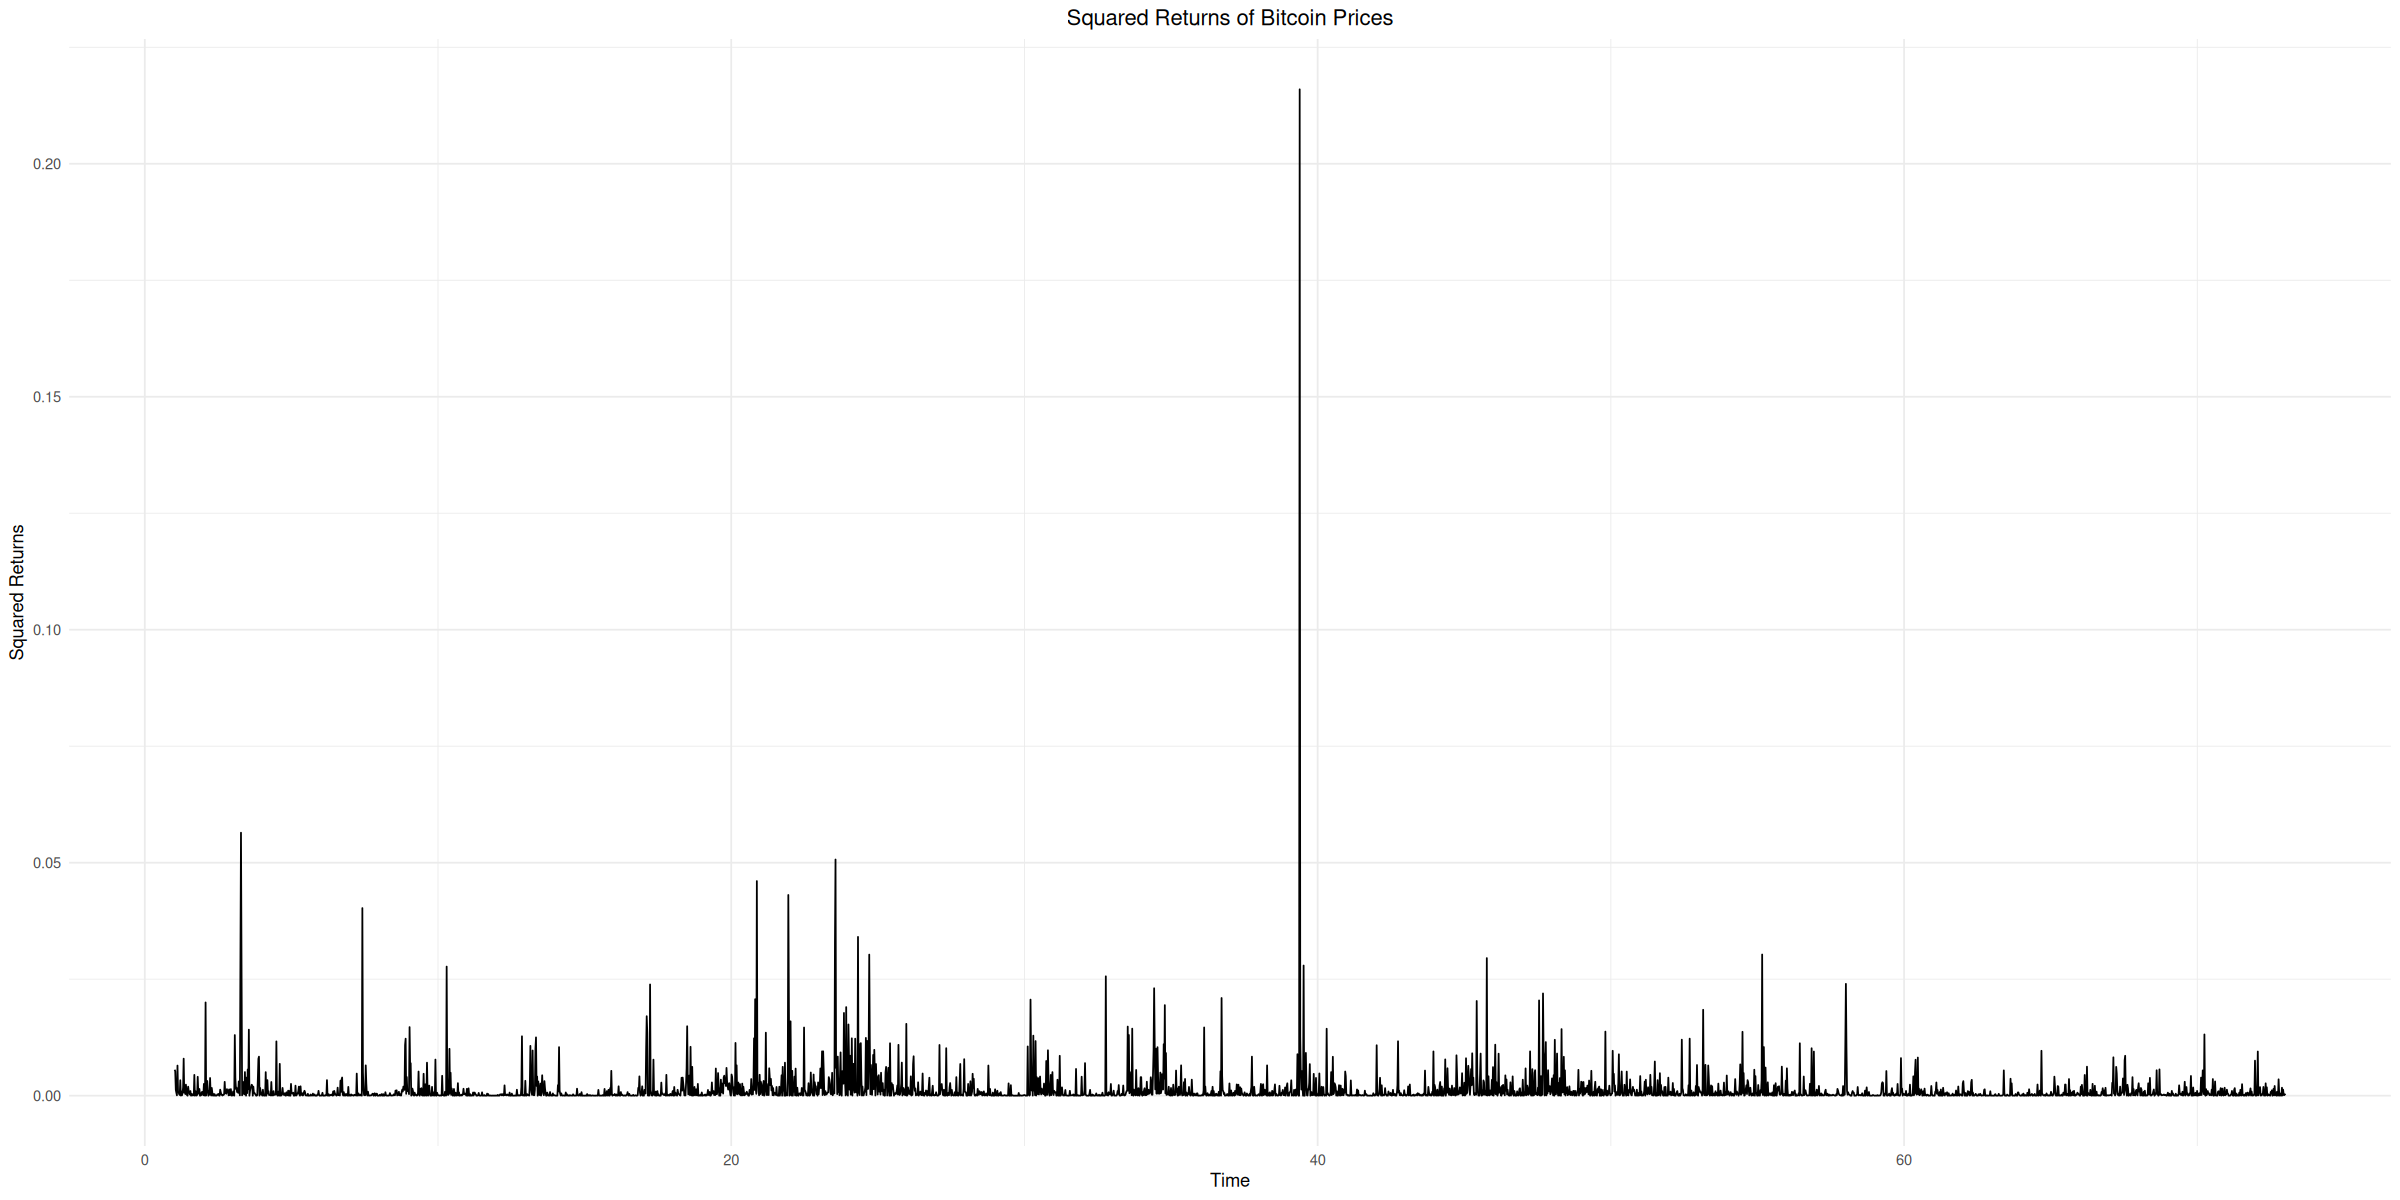

In [90]:
# Plot squared returns
p6 <- autoplot(squared_returns) +
  labs(title = "Squared Returns of Bitcoin Prices",
       x = "Time", y = "Squared Returns") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(p6)


In [91]:
# Test for ARCH effects
Box.test(squared_returns, lag = 12, type = "Ljung-Box")


	Box-Ljung test

data:  squared_returns
X-squared = 178.59, df = 12, p-value < 2.2e-16
